In [8]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings("ignore", category=UserWarning)  # UserWarning 억제
warnings.filterwarnings("ignore", category=FutureWarning) # FutureWarning 억제

# 심볼 목록 정의
crypto_symbols = ["ETH-USD","XRP-USD", "DOGE-USD", "ADA-USD","SOL-USD","UNI7083-USD", "CRV-USD","WIF-USD","FTM-USD","LTC-USD","XLM-USD","SUI20947-USD"
                  "HBAR-USD","SAND-USD"        ]

# 현재 날짜와 시간 가져오기
now = datetime.now()
current_hour = now.replace(minute=0, second=0, microsecond=0)  # 현재 시각의 시 만큼 자르고 더 작은 단위는 0으로 설정

# 데이터 가져오기
crypto_data = yf.download(crypto_symbols, start=current_hour - timedelta(days=30), end=current_hour, interval="1h").fillna(method='ffill')

# Close 가격만 선택
close_prices = crypto_data['Close']

# 오늘 포함된 데이터 확인
print(close_prices.tail(2))

[*********************100%***********************]  13 of 13 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['SUI20947-USDHBAR-USD']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Ticker                      ADA-USD   CRV-USD  DOGE-USD      ETH-USD  \
2024-12-21 06:00:00+00:00  0.982633  0.915643  0.346130  3524.626953   
2024-12-21 07:00:00+00:00  0.992270  0.908233  0.347494  3524.886230   

Ticker                      FTM-USD     LTC-USD  SAND-USD     SOL-USD  \
2024-12-21 06:00:00+00:00  1.074410  104.909027  0.624541  198.940643   
2024-12-21 07:00:00+00:00  1.081228  104.680931  0.623475  199.059814   

Ticker                     SUI20947-USDHBAR-USD  UNI7083-USD   WIF-USD  \
2024-12-21 06:00:00+00:00                   NaN    14.614115  2.200715   
2024-12-21 07:00:00+00:00                   NaN    14.504622  2.235623   

Ticker                      XLM-USD   XRP-USD  
2024-12-21 06:00:00+00:00  0.385131  2.360497  
2024-12-21 07:00:00+00:00  0.386110  2.358613  


In [2]:
# 일반 수익률 계산
returns = crypto_data['Close'].pct_change(fill_method=None).dropna()  # 결측치를 채우지 않음

# 변동성 계산 함수
def calculate_volatility(data, window):
    return data.rolling(window=window).std()

# 각 주기에 대한 변동성 계산
volatility_1h = returns.std() * np.sqrt(1)  # 1시간 변동성
volatility_12h = returns.resample('12h').std().mean() * np.sqrt(12)  # 4시간 변동성
volatility_1D = returns.resample('D').std().mean() * np.sqrt(24)  # 일간 변동성
volatility_3D = returns.resample('3D').std().mean() * np.sqrt(24 * 3)  # 주간 변동성

# 포트폴리오 기대 수익률 (평균으로 설정)
portfolio_return = returns.mean()

# 샤프 지수 계산 (일간 기반)
sharpe_1D = (portfolio_return * 24 - 0) / volatility_1D  # 일간 샤프 비율


# 결과를 데이터프레임으로 정리
volatility_df = pd.DataFrame({
    '1H': (volatility_1h * 100).round(1),
    '12H': (volatility_12h * 100).round(1),
    '1D': (volatility_1D * 100).round(1),
    '3D': (volatility_3D * 100).round(1),
    'Sharpe': sharpe_1D.round(2),
})

# Daily 기준으로 내림차순 정렬
volatility_df_sorted = volatility_df.sort_values(by='1D')

# 결과 출력
print(volatility_df_sorted)

               1H  12H    1D    3D  Sharpe
Ticker                                    
BTC-USD       0.6  1.8   2.6   4.5    0.04
ETH-USD       0.8  2.4   3.6   6.3    0.13
SOL-USD       0.9  2.9   4.3   7.5   -0.13
AVAX-USD      1.4  4.4   6.4  11.3    0.14
SUI20947-USD  1.4  4.6   6.7  11.7    0.19
AAVE-USD      1.6  5.0   7.3  13.0    0.39
LINK-USD      1.6  5.1   7.4  13.1    0.28
FTM-USD       1.8  5.6   8.3  14.7    0.23
XRP-USD       1.9  5.7   8.4  14.4    0.34
ENS-USD       1.9  5.9   8.6  15.4    0.35
CRV-USD       2.2  6.9  10.0  17.7    0.36


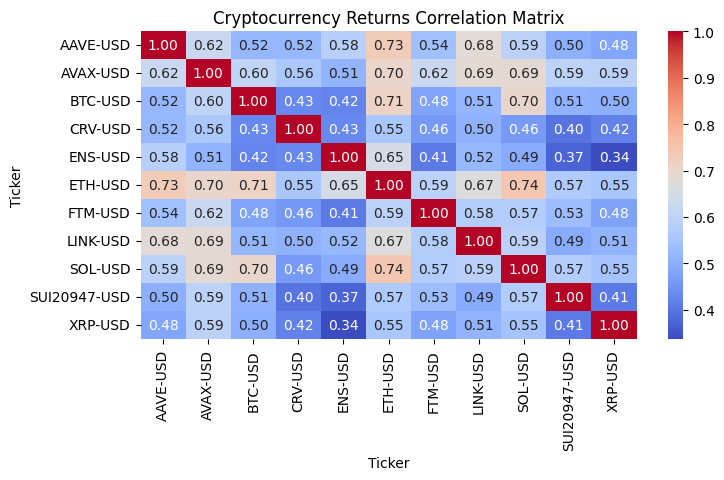

In [3]:
# 상관관계 계산
correlation_matrix = returns.corr()

# 상관관계 시각화
plt.figure(figsize=(8, 4))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Cryptocurrency Returns Correlation Matrix')
plt.show()

In [4]:
### 최근 종가 가져오기
recent_close_prices = crypto_data['Close'].iloc[-1]  # 최신 종가

# recent_close_prices['BONK-USD'] = recent_close_prices['BONK-USD'] * 1000

# 변동성을 기준으로 가격 계산
Down_prices_1D = recent_close_prices * (1 - (volatility_1D))  # 12시간 변동성 적용
Down_prices_3D = recent_close_prices * (1 - (volatility_3D))  # 일간 변동성 적용
Up_prices_1D = recent_close_prices * (1 + (volatility_1D))  # 일간 변동성 적용
Up_prices_3D = recent_close_prices * (1 + (volatility_3D))  # 일간 변동성 적용


# 결과를 새로운 데이터프레임으로 정리
adjusted_prices_df = pd.DataFrame({
    'Down Price (1D)': Down_prices_1D.round(4),
    'Down Price (3D)': Down_prices_3D.round(4),
    'Up Price (1D)': Up_prices_1D.round(4),
    'Up Price (3D)': Up_prices_3D.round(4)
})
# 결과 출력
print("\nAdjusted Prices DataFrame:")
print(adjusted_prices_df)


Adjusted Prices DataFrame:
              Down Price (1D)  Down Price (3D)  Up Price (1D)  Up Price (3D)
Ticker                                                                      
AAVE-USD             313.3621         294.1293       362.4682       381.7011
AVAX-USD              39.2965          37.2266        44.6545        46.7244
BTC-USD            96433.0158       94512.1527    101542.6717    103463.5348
CRV-USD                0.8171           0.7472         0.9993         1.0693
ENS-USD               35.4234          32.7947        42.0840        44.7127
ETH-USD             3397.6319        3302.4747      3652.1406      3747.2977
FTM-USD                0.9916           0.9224         1.1709         1.2400
LINK-USD              22.8048          21.4016        26.4297        27.8329
SOL-USD              190.5125         184.2164       207.6072       213.9032
SUI20947-USD           4.4922           4.2517         5.1343         5.3748
XRP-USD                2.1602           2.0201  

In [5]:
returns = crypto_data['Close'].pct_change().dropna()

# 사용자로부터 각 암호화폐의 수량 입력 받기
quantities = ({
  "ADA-USD": 000,
  "BTC-USD": 0.09,
  "CRV-USD": 500,
  "DOGE-USD": 00,
  "ETH-USD": 000,
  "FTM-USD": 300,
  "HBAR-USD": 500,
  "SOL-USD": 40,
  "SUI20947-USD": 500,
  "SAND-USD": 500,
  "UNI7083-USD": 0.0,
  "WIF-USD": 100,
  "XLM-USD": 500,
  "XRP-USD": 8,
    })



# 현재 가격 가져오기
latest_prices = crypto_data['Close'].iloc[-1]

# 포트폴리오의 각 암호화폐의 현재 가치를 계산
portfolio_value = sum(latest_prices[symbol] * quantities[symbol] for symbol in quantities.keys())

# 포트폴리오 비중 계산
weights = {symbol: (latest_prices[symbol] * quantities[symbol]) / portfolio_value for symbol in quantities.keys()}

# Pandas Series로 변환
weights = pd.Series(weights)

crypto_symbols = list(weights.index)

# 공분산 행렬 계산
cov_matrix = returns.cov()

# 포트폴리오 변동성 계산 (일간으로 변환)
portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
portfolio_volatility_hourly = np.sqrt(portfolio_variance)
portfolio_volatility_daily = portfolio_volatility_hourly * np.sqrt(24)  # 하루 동안의 변동성

# 일간 포트폴리오 기대 수익률 계산
portfolio_mean_hourly = np.dot(weights.T, returns.mean())
portfolio_mean_daily = (1 + portfolio_mean_hourly) ** 24 - 1  # 복리 수익률 변환

# 95% 신뢰수준에서의 VaR 계산
z_score = norm.ppf(0.05)
var_95_daily = -z_score * portfolio_volatility_daily * portfolio_value  # 포트폴리오 가치

# 결과 출력
print(f"Daily Portfolio Volatility: {portfolio_volatility_daily:.2%}")
print(f"Daily Portfolio Mean: {portfolio_mean_daily:.2%}")
print(f"95% VaR (daily, value): ${var_95_daily:,.2f} ({var_95_daily/portfolio_value:.2%})")
print(f"Portfolio_Value: {portfolio_value:,.2f}")

Daily Portfolio Volatility: 5.37%
Daily Portfolio Mean: 1.66%
95% VaR (daily, value): $1,659.36 (8.83%)
Portfolio_Value: 18,787.99


In [6]:
# 각 코인별 VaR 계산 및 출력
individual_vars = []  # 각 코인별 VaR를 저장할 리스트

for symbol in crypto_symbols:
    weight = weights[symbol]
    if weight > 0:  # 롱 포지션이 있는 경우에만 VaR 계산
        individual_mean = returns[symbol].mean() * 24  # 일간 기대 수익률
        individual_volatility = returns[symbol].std() * np.sqrt(24)  # 일간 변동성

        individual_var_dollar = weight * (-z_score * individual_volatility * portfolio_value)  # 금액 손실
        individual_var_percent = (individual_var_dollar / portfolio_value) * 100  # 퍼센트 손실

        print(f"{symbol} : ${individual_var_dollar:.2f} ({individual_var_percent:.2f}%)")
        individual_vars.append(individual_var_dollar)  # VaR를 리스트에 추가

# 95% VaR의 총합 계산 및 출력
total_var_95 = sum(individual_vars)
print(f"\nTotal 95% VaR (daily, value): ${total_var_95:.2f}")

BTC-USD : $407.01 (2.17%)
AAVE-USD : $342.45 (1.82%)
ENS-USD : $241.12 (1.28%)
FTM-USD : $78.99 (0.42%)
LINK-USD : $320.84 (1.71%)
SUI20947-USD : $167.39 (0.89%)
XRP-USD : $178.02 (0.95%)

Total 95% VaR (daily, value): $1735.81


In [7]:
# 공분산 행렬 계산
cov_matrix = returns.cov()
mean_returns = returns.mean()

# 코인 그룹 나누기 (예시) - 실제 코인 목록에 맞춰 수정해야 합니다.
first_group = ["BTC-USD","SOL-USD","XRP-USD", "ETH-USD"]
second_group = ["AAVE-USD","AVAX-USD", "CRV-USD", "ENS-USD", "FTM-USD","LINK-USD","SUI20947-USD"]

# crypto_symbols 리스트 중복 제거
crypto_symbols = list(set(first_group + second_group))

crypto_symbols = first_group + second_group

# first_group와 second_group에 해당하는 인덱스 얻기
first_indices = [crypto_symbols.index(symbol) for symbol in first_group]
second_indices = [crypto_symbols.index(symbol) for symbol in second_group]


# 최소 변동성과 최대 샤프 비율 최적화 함수 (수정)
def optimize_portfolio(weights):
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = portfolio_return / portfolio_volatility
    return -sharpe_ratio # 샤프 비율 최대화를 위해 - 부호를 제거

# 초기 비중 설정
num_assets = len(crypto_symbols)
initial_weights = np.array([1.0 / num_assets] * num_assets)

# 제약 조건 (수정)
constraints = (
    {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},  # 전체 비중 1
    {'type': 'eq', 'fun': lambda weights: np.sum(weights[first_indices]) - 0.8},  # FIRST 그룹 비중 80%
    {'type': 'eq', 'fun': lambda weights: np.sum(weights[second_indices]) - 0.2}  # SECOND 그룹 비중 20%
)
bounds = tuple((0, 1) for asset in range(num_assets))

# 최적화 실행 및 결과 출력 (기존 코드 동일)
optimized_results = minimize(optimize_portfolio, initial_weights, method='trust-constr', bounds=bounds, constraints=constraints, options={'maxiter':1000}) #maxiter 추가


# 최적화된 비중
optimal_weights = optimized_results.x
optimal_weights=pd.Series(optimized_results.x, index=crypto_symbols) # index 추가
optimal_weights = optimal_weights.sort_values(ascending=False)

optimal_return = np.dot(optimal_weights, mean_returns) * 24
optimal_volatility = np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights))) * np.sqrt(24)
optimal_sharpe = optimal_return / optimal_volatility

print("Optimal Portfolio:")
for i, weight in enumerate(optimal_weights.round(3)):
    print(f"{optimal_weights.index[i]}: {weight:.1%}") #index 사용

print(f"\nExpected Daily Return: {optimal_return:.2%}")
print(f"Daily Volatility: {optimal_volatility:.2%}")
print(f"Sharpe Ratio: {optimal_sharpe:.2f}")

Optimal Portfolio:
ETH-USD: 20.9%
BTC-USD: 20.6%
XRP-USD: 19.4%
SOL-USD: 19.1%
AAVE-USD: 3.7%
SUI20947-USD: 3.7%
ENS-USD: 3.0%
CRV-USD: 2.8%
LINK-USD: 2.7%
AVAX-USD: 2.5%
FTM-USD: 1.6%

Expected Daily Return: 1.79%
Daily Volatility: 5.55%
Sharpe Ratio: 0.32
